<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Compare-composers" data-toc-modified-id="Compare-composers-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Compare composers</a></span></li><li><span><a href="#Energy-for-simulation-esimations" data-toc-modified-id="Energy-for-simulation-esimations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Energy for simulation esimations</a></span></li><li><span><a href="#Compare-orderers" data-toc-modified-id="Compare-orderers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compare orderers</a></span></li><li><span><a href="#Compare-distributions-of-treewidth" data-toc-modified-id="Compare-distributions-of-treewidth-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare distributions of treewidth</a></span><ul class="toc-item"><li><span><a href="#Different-seeds" data-toc-modified-id="Different-seeds-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Different seeds</a></span></li></ul></li><li><span><a href="#CLI" data-toc-modified-id="CLI-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>CLI</a></span></li><li><span><a href="#Nbdev-stuff" data-toc-modified-id="Nbdev-stuff-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Nbdev stuff</a></span></li></ul></div>

# Benchmark QAOA Energy circuits 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

from qtensor_specs.time_vs_flop import ex
from qtensor_specs.time_vs_flop import (
    step_flops
    ,max_mem
    ,step_sim_time
)

from qtensor import toolbox

/home/plate/.local/lib/python3.8/site-packages/qiskit/__init__.py:63: RuntimeWarning: Could not import the Aer provider from the qiskit-aer package. Install qiskit-aer or check your installation.
  warnings.warn('Could not import the Aer provider from the qiskit-aer '
/home/plate/.local/lib/python3.8/site-packages/qiskit/__init__.py:73: RuntimeWarning: Could not import the IBMQ provider from the qiskit-ibmq-provider package. Install qiskit-ibmq-provider or check your installation.
  warnings.warn('Could not import the IBMQ provider from the '


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#export
from cartesian_explorer import caches
from cartesian_explorer import parallels

ex.set_cache(cache=caches.JobLibCache(cachedir='../../data/cache/qaoa_bench'))

@ex.provider
def qaoa_energy_tws(graph, p, ordering_algo='greedy', composer_type='cone'):
    twidths = toolbox.qaoa_energy_tw_from_graph(graph, p, ordering_algo=ordering_algo, composer_type=composer_type)
    return tuple(twidths)

In [4]:
#export

@ex.provider
def qaoa_energy_max_tws(qaoa_energy_tws):
    return max(qaoa_energy_tws)

@ex.provider
def qaoa_energy_med_tws(qaoa_energy_tws):
    return np.median(qaoa_energy_tws)

@ex.provider
def qaoa_energy_min_tws(qaoa_energy_tws):
    return np.min(qaoa_energy_tws)
    
    

In [161]:
@ex.provider
def time_estimate(qaoa_energy_tws):
    n_nodes = 1
    n_processes = 56*n_nodes
    reality_factor = 30
    #power = 2e6
    return reality_factor*np.sum(np.power(2, qaoa_energy_tws))/n_processes/1e9

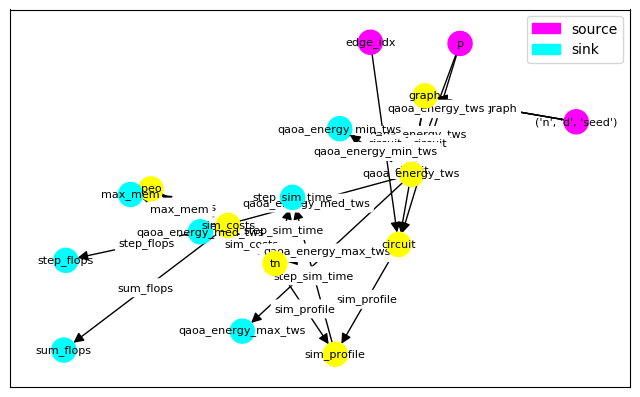

In [5]:
f =  ex.draw_dependency_graph()


## Compare composers

Text(0.5, 81.39814814814811, 'Graph size N')

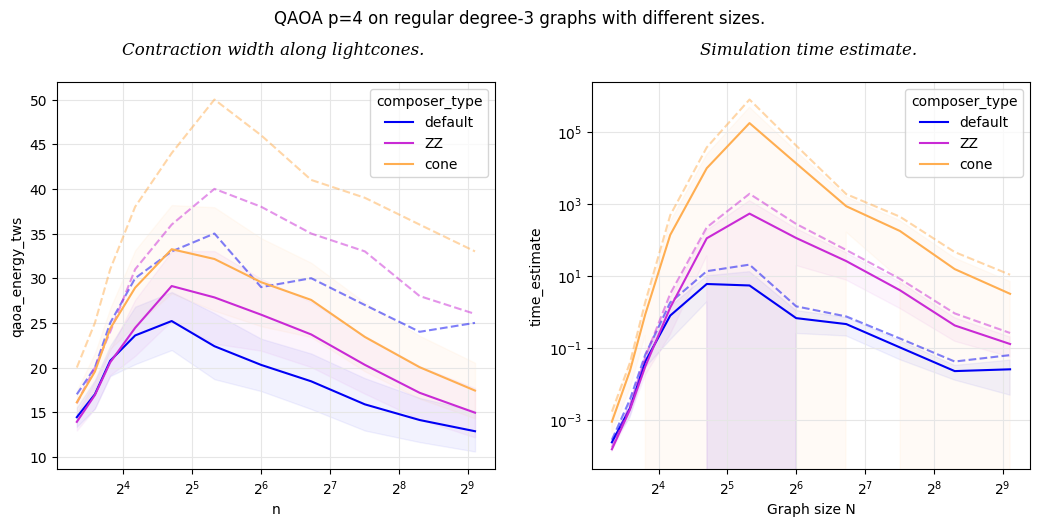

In [162]:
def plot_fn(x, twds, **kwargs):
    twds = [np.array(list(x)) for x in twds]
    means = np.array([np.mean(x) for x in twds])
    maxs = [np.max(x) for x in twds]
    plt.plot(x, means, **kwargs)
    label = kwargs.get('label')
    kwargs['label'] = None
    plt.plot(x, maxs,  '--', alpha=0.5, **kwargs)
    
    std = np.array([np.std(x) for x in twds])
    plt.fill_between(x, means+std, means-std, alpha=0.05, color=kwargs.get('color'))
    plt.xscale('log', basex=2)

p = 4
Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10

fig = ex.plot_variables(('qaoa_energy_tws', 'time_estimate'), processes=1, plot_func=plot_fn,
                        distribution_var='seed',
                        composer_type=['default', 'ZZ', 'cone'], n=Ns, p=[p],
                        seed=[100, 101, 102, 103, 104], d=[3])
ax1, ax2 = fig.axes

ax1.set_title("Contraction width along lightcones. \n"
          ,style='italic'
          ,family='serif'
         )

ax2.set_title("Simulation time estimate. \n"
          ,style='italic' ,family='serif'
         )
fig.set_size_inches(10.5, 5.5)
fig.suptitle(f"QAOA p={p} on regular degree-3 graphs with different sizes.")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


ax2.set_yscale('log')
plt.xlabel('Graph size N')

## Energy for simulation esimations

In [70]:
@ex.provider
def quantum_time_estimate(graph, p):
    n_edges = graph.number_of_edges()
    n_nodes = graph.number_of_nodes()
    return ((n_edges*500e-9 + n_nodes*200e-9)*p + n_nodes*200e-9)*10000

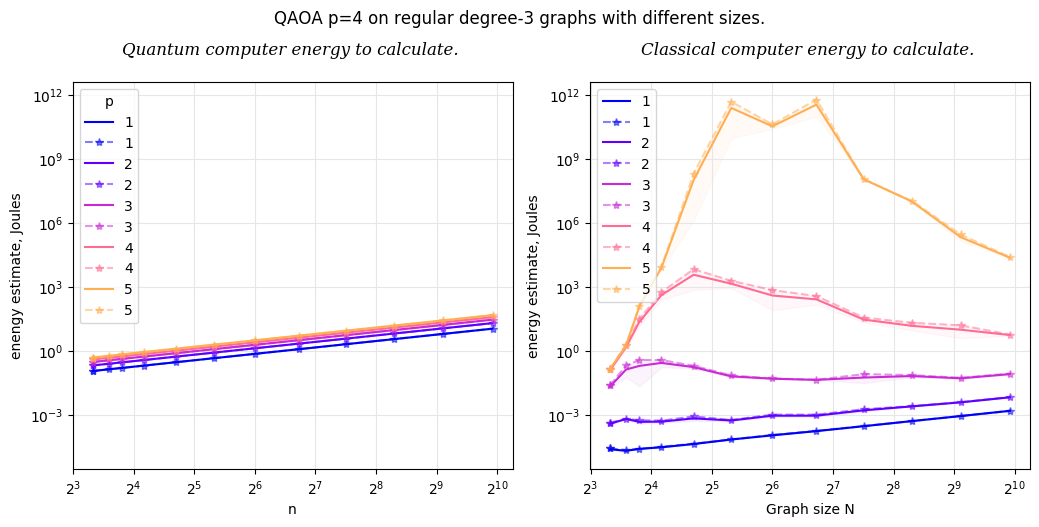

In [87]:

def plot_fn(x, twds, **kwargs):
    twds = [np.array(list(x)) for x in twds]
    means = np.array([np.mean(x) for x in twds])
    maxs = [np.max(x) for x in twds]
    plt.plot(x, means, **kwargs)
    plt.plot(x, maxs,  '*--', alpha=0.5, **kwargs)
    
    std = np.array([np.std(x) for x in twds])
    plt.fill_between(x, means+std, means-std, alpha=0.05, color=kwargs.get('color'))
    plt.xscale('log', basex=2)

p = 4
Ns = 2*(.5*np.pi**(np.arange(0, 13)/2)).astype(np.int) + 10

fig = ex.plot_variables(('quantum_time_estimate', 'time_estimate'), processes=1, plot_func=plot_fn,
                        distribution_var='seed',
                        composer_type=['default'], p=[1,2,3,4,5], n=Ns,
                        seed=[100, 101], d=[3])
ax1, ax2 = fig.axes

fig.set_size_inches(10.5, 5.5)

ax1.set_title("Quantum computer energy to calculate. \n"
          ,style='italic'
          ,family='serif'
         )

ax2.set_title("Classical computer energy to calculate. \n"
          ,style='italic' ,family='serif'
         )
fig.suptitle(f"QAOA p={p} on regular degree-3 graphs with different sizes.")

ax1.set_ylabel('enengy estimate, Joules')
ax2.set_ylabel('energy estimate, Joules')

ax1.get_shared_y_axes().join(ax1, ax2)

ax2.set_yscale('log')
ax1.set_yscale('log')
ax2.legend(loc='upper left')
plt.xlabel('Graph size N')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Compare orderers

Text(0.5, 81.39814814814817, 'Graph size N')

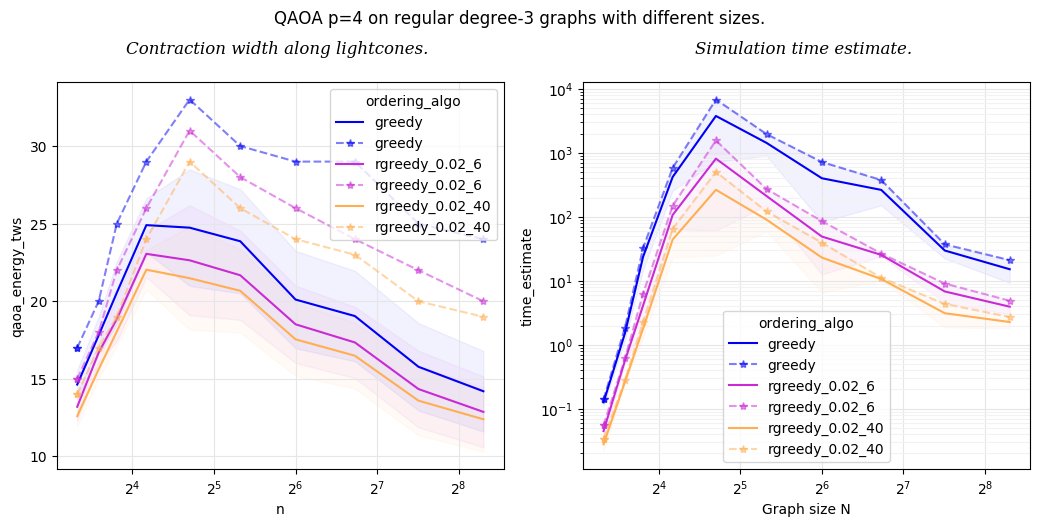

In [154]:
def plot_fn(x, twds, **kwargs):
    twds = [np.array(list(x)) for x in twds]
    means = np.array([np.mean(x) for x in twds])
    maxs = [np.max(x) for x in twds]
    plt.plot(x, means, **kwargs)
    plt.plot(x, maxs,  '*--', alpha=0.5, **kwargs)
    
    std = np.array([np.std(x) for x in twds])
    plt.fill_between(x, means+std, means-std, alpha=0.05, color=kwargs.get('color'))
    plt.xscale('log', basex=2)

p = 4
Ns = 2*(.5*np.pi**(np.arange(0, 11)/2)).astype(np.int) + 10

#p=3 0.02_6
#p=3 0.1_40


fig = ex.plot_variables(('qaoa_energy_tws', 'time_estimate'), processes=1, plot_func=plot_fn,
                        distribution_var='seed',
                        ordering_algo = ['greedy', 'rgreedy_0.02_6', 'rgreedy_0.02_40'],
                        composer_type=['default'], n=Ns, p=[p],
                        seed=[100, 101], d=[3])
ax1, ax2 = fig.axes

ax1.set_title("Contraction width along lightcones. \n"
          ,style='italic'
          ,family='serif'
         )

ax2.set_title("Simulation time estimate. \n"
          ,style='italic' ,family='serif'
         )
fig.set_size_inches(10.5, 5.5)
fig.suptitle(f"QAOA p={p} on regular degree-3 graphs with different sizes.")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


ax2.set_yscale('log')
plt.xlabel('Graph size N')

## Compare distributions of treewidth

In [19]:
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(
    color=['#D94430', '#009FF5', '#ca9502', '#116A43', '#4B1B4A']
    
)

In [151]:
ndist = [64, 156, 1024]
p = 5
tws = ex.map_variables(('qaoa_energy_tws',), n=ndist, composer_type=['default'], ordering_algo=['rgreedy_0.02_10'],
                       seed=[100], p=[p], d=[3])

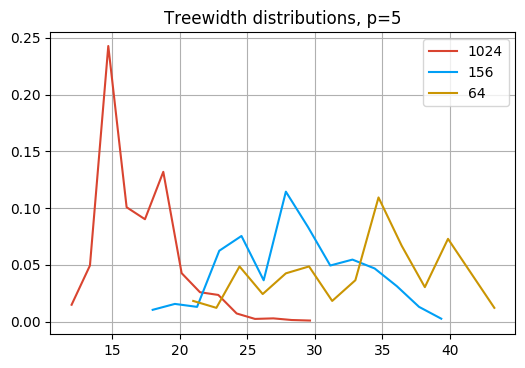

In [152]:
nbins = 14
plt.figure(dpi=100)
y, x = np.histogram(tws[0][-1], bins=nbins, density=True)
plt.plot(x[:-1],y, label=ndist[-1],)
y, x = np.histogram(tws[0][-2], bins=nbins, density=True)
plt.plot(x[:-1],y, label=ndist[-2],)
y, x = np.histogram(tws[0][-3], bins=nbins, density=True)
plt.plot(x[:-1],y, label=ndist[-3],)

plt.title('Treewidth distributions, p=5')
plt.legend()
plt.grid()

### Different seeds

In [32]:
seeds = [100, 101, 102, 103]
tws_vs_seed = []
for seed in seeds:
    tw_ = ex.get_variable('qaoa_energy_tws', n=Ns[13], seed=seed, p=4, d=3)
    tws_vs_seed.append(tw_)
    

seed=100 Max tw=42
seed=101 Max tw=34
seed=102 Max tw=30
seed=103 Max tw=33


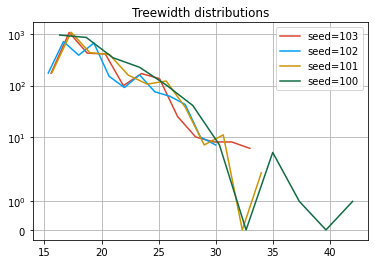

In [59]:
nbins = 12
y, x = np.histogram(tws_vs_seed[3], bins=nbins, )
plt.plot(x[1:],y, '-', label='seed=103')
y, x = np.histogram(tws_vs_seed[2], bins=nbins, )
plt.plot(x[1:],y, '-', label='seed=102')
y, x = np.histogram(tws_vs_seed[1], bins=nbins, )
plt.plot(x[1:],y, '-', label='seed=101')
y, x = np.histogram(tws_vs_seed[0], bins=nbins, )
plt.plot(x[1:],y, '-', label='seed=100')

for seed, t in zip(seeds,tws_vs_seed):
    print(f'{seed=} Max tw={np.max(t)}')

plt.yscale('symlog')
plt.title('Treewidth distributions')
plt.legend()
plt.grid()

## CLI

In [7]:
#export

from qtensor_specs.time_vs_flop import cli
import click

@click.option('-B', '--backend', default='numpy')
@click.option('-M', '--max-memory', default=3e8)
@click.option('-s', '--seed', default=SEED)
@click.option('-O', '--ordering_algo', default='greedy'
              ,help=("One of (greedy, tamaki, tamaki_{wait_time})"
                     "'tamaki_15' means heuristic solver running for 15 seconds per graph"
                    )
             )
def qaoa_simulate(backend='numpy', seed=108
                  max_memory=1e8,
                  ordering_algo='greedy',
                 ):
    


In [ ]:

o

In [135]:
from cartesian_explorer import parallels
import time

parallel = parallels.Ray(processes=3)

K = 100
y = np.empty(K)
x = np.array([10000]*K)

def payload(N):
    product = 1
    for j in range(N):
        product *= np.sin(j/N)**2 + np.cos(j/N)**2
    return product

start = time.time()
x = parallel.map(payload, [10000]*K)
print(sum(x))
end = time.time()
print(f'Duration = {end-start}')

2020-11-05 22:41:35,610	ERROR worker.py:643 -- Calling ray.init() again after it has already been called.


99.99999999998829
Duration = 0.8707103729248047


In [136]:
from cartesian_explorer import parallels
import time

parallel = parallels.Thread(processes=3)

K = 100
y = np.empty(K)
x = np.array([10000]*K)

def payload(N):
    product = 1
    for j in range(N):
        product *= np.sin(j/N)**2 + np.cos(j/N)**2
    return product

start = time.time()
x = parallel.map(payload, [10000]*K)
print(sum(x))
end = time.time()
print(f'Duration = {end-start}')

99.99999999998829
Duration = 3.342017412185669


[autoreload of cartesian_explorer.parallels failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/p

In [ ]:
importlib.im

In [132]:
ray.state

## Nbdev stuff

In [221]:
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(
    color=['#D94430', '#009FF5', '#ca9502', '#116A43', '#4B1B4A']
    
)

In [ ]:
from nbdev.export  import *
notebook2script()